<a href="https://colab.research.google.com/github/coryroyce/emnist_letter_exploration_and_prediction/blob/main/dev_notebooks/Letter_Exploration_and_Classification_V03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Letter Classification

Updated: 12/5/2021

Goals: 

*   Import and prep hand written letters
*   Visualize data
*   Apply Data Reduction Techniques
*   Apply vaious mehtods of classificaion and compare resulsts



# Load Packages

Install needed packages for this project

In [1]:
# Install the emnist package for loading image data easily
!pip install emnist
!pip install umap-learn

# Clear output for this cell
from IPython.display import clear_output
clear_output()

Import packages used

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import seaborn as sns

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import decomposition
from sklearn import manifold
from sklearn import datasets
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import umap

import tensorflow as tf

# Load Datasets

For this project we are choose to do the EMNIST data set since it is less used in examples and tutorials normally just the numerical 0-9 digits data set.



In [3]:
import emnist

In [4]:
emnist.gzip

<module 'gzip' from '/usr/lib/python3.7/gzip.py'>

For this project I will focus on just the letters data set with balanced class examples containing 145,600 examples. (Smaller subsets may be taken later for visualization)

In [5]:
x,y = emnist.extract_training_samples('balanced')
# x_train,y_train = emnist.extract_training_samples('balanced')
# x_test,y_test = emnist.extract_test_samples('balanced')

Show that there 26 unique labels

In [6]:
len(np.unique(y))

47

Create the list of labels rather than the provided integer value

In [7]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
          'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
          'a', 'b', 'd', 'e', 'f','g', 'h', 'n', 'q', 'r', 't']

labels_dict = {key: value for key, value in enumerate(labels)}

# Create a reversed dictionary to help with plotting
labels_dict_reversed = {value : key for (key, value) in labels_dict.items()}

In [8]:
len(labels)

47

Create a Pandas Dataframe for the data

In [9]:
def create_emnist_df(x,y,labels_dict):
  # Define the pixel values as a dataframe
  image_vector_size = 28*28
  x_flattened = x.reshape(x.shape[0], image_vector_size)
  df_features = pd.DataFrame(x_flattened)

  # Define the label column
  df_labels = pd.DataFrame(y, columns=['label'])
  # Map the labels from the integers
  df_labels['label'] = df_labels['label'].map(labels_dict)

  # Merge the features and labels
  # df = pd.merge(df_labels, df_df_features, left_index=True, right_index=True)

  return df_features, df_labels

In [10]:
df_features, df_labels = create_emnist_df(x,y,labels_dict)
df_features.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
df_labels.head(3)

,label
0,r
1,a
2,n


Create a smaller subset of features since some methods are computationally expensive

In [12]:
def get_subset_of_image_data(df_features, df_labels):
  df_temp = pd.merge(df_labels, df_features, left_index=True, right_index=True)

  # Get stratified subset of 100 of each characters
  df_sample = df_temp.groupby('label', group_keys = False).apply(lambda x: x.sample(100, random_state = 3))

  # Also limit the data set to just Capital Letters
  capital_letters = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
  df_sample = df_sample[df_sample['label'].isin(capital_letters)]

  df_sample.reset_index(drop = True, inplace = True)

  # Separate features from lables
  df_labels_temp = pd.DataFrame(df_sample, columns=['label'])
  df_features_temp = df_sample.drop('label', axis = 1)

  return df_features_temp, df_labels_temp


In [13]:
# Apply the subset function to reduce the data set to a balanced 2,600 records (100 of each letter)
df_features, df_labels = get_subset_of_image_data(df_features, df_labels)

print(f'The sampled dataframes now have {df_features.shape[0]:,}')

The sampled dataframes now have 2,600


Plot the first data point to verify

In [14]:
def plot_emnist_image_by_idx(idx, df_features):
  plt.figure(figsize=(4,4))
  # Reshape the dataframe from 1d to 2d pixel array for given idx (prefer 28 X 28)
  grid_data = df_features.loc[idx].values.reshape(28,28)
  # Add title
  plt.title(f'Label: {df_labels.iat[idx,0]}')
  # Remove axes lables and ticks
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)
  # Plot above grid image with cmap as gray and interpolation as none
  plt.imshow(grid_data, interpolation='none', cmap='gray')

  #display plot
  plt.show()

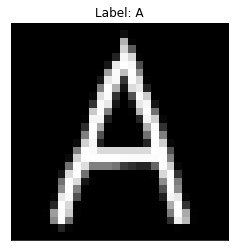

In [15]:
idx = 0
plot_emnist_image_by_idx(idx = idx, df_features = df_features)


# Data Reduction

## Principle Component Analysis (PCA)

Apply PCA to the emnist letter data set

Standarize the data

In [16]:
df_standard = StandardScaler().fit_transform(df_features)
print(f'df_standrd has {df_standard.shape[0]:,} rows and {df_standard.shape[1]} columns.')

df_standrd has 2,600 rows and 784 columns.


Instantiate a PCA model from sklearn

In [17]:
pca = decomposition.PCA() # decomposition was imported above from sklearn

# Set the numer of components (2 for 2D visualizations)
pca.n_components = 2

# Fit the PCA model on the data
pca_fitted = pca.fit_transform(df_standard)
print(f'pca_fitted has {pca_fitted.shape[0]:,} rows and {pca_fitted.shape[1]} columns.')

pca_fitted has 2,600 rows and 2 columns.


Create a new dataframe for plotting

In [18]:
# Need to add in the Letter index's for colring in the plot
labels_dict_reveresed = {value : key for (key, value) in labels_dict.items()}


df_pca = pd.DataFrame({'1st Principal Component' : pca_fitted.T[0],
                       '2nd Principal Component' : pca_fitted.T[1],
                       'label' : df_labels['label'],
                       'label_int' : df_labels['label'].map(labels_dict_reveresed)})

In [19]:
df_pca.head()

,1st Principal Component,2nd Principal Component,label,label_int
0,-5.029054,-0.161118,A,10
1,0.541887,-7.092108,A,10
2,-5.608934,1.195092,A,10
3,-0.837891,-6.946132,A,10
4,-6.327567,-0.963059,A,10


Plot the PCA data in 2D with Seaborn

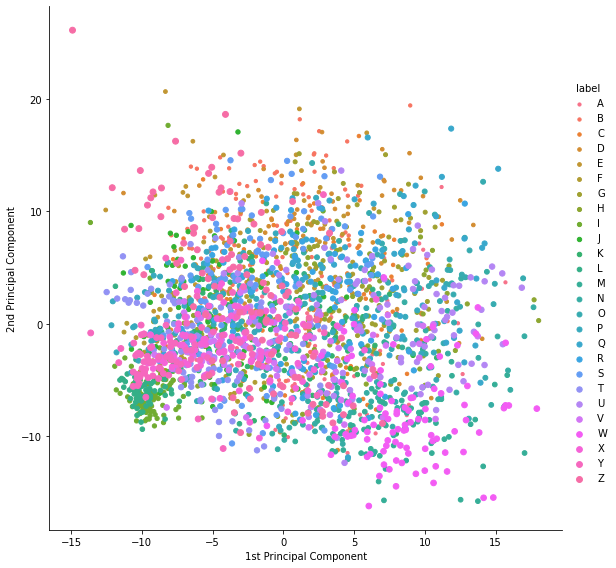

In [20]:
sns.FacetGrid(df_pca, hue='label',height=8).map(plt.scatter, '1st Principal Component', '2nd Principal Component', 'label_int').add_legend()
plt.show()

Plot the variance explained by the various number of components

In [21]:
pca.n_components = 784

pca_fitted = pca.fit_transform(df_standard)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)

#cumulative sum of the percentage_var_explained
cumulative_explained_variance = np.cumsum(percentage_var_explained)

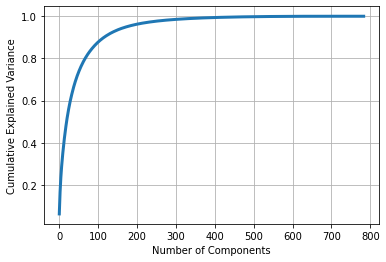

In [22]:
plt.figure(figsize=(6,4))
plt.plot(cumulative_explained_variance,linewidth=3)
plt.grid()

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

Based on this graph we get ~95% of the data at 200 components.
We could do an other PCA with n = 200 and re plot the before an after image to see the "data loss" through PCA.

## Singular Value Decomposition (SVD)

Apply SVD to the image data set

In [23]:
svd = decomposition.TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd_fitted = svd.fit_transform(df_standard)

print(f'svd_fitted has {svd_fitted.shape[0]:,} rows and {svd_fitted.shape[1]} columns.')

svd_fitted has 2,600 rows and 2 columns.


Create a new dataframe for plotting

In [24]:
# Need to add in the Letter index's for colring in the plot
labels_dict_reveresed = {value : key for (key, value) in labels_dict.items()}


df_svd = pd.DataFrame({'1st Component' : svd_fitted.T[0],
                       '2nd Component' : svd_fitted.T[1],
                       'label' : df_labels['label'],
                       'label_int' : df_labels['label'].map(labels_dict_reveresed)})

In [25]:
df_svd.head()

,1st Component,2nd Component,label,label_int
0,-5.029522,-0.160306,A,10
1,0.541989,-7.093234,A,10
2,-5.609588,1.194514,A,10
3,-0.837656,-6.948314,A,10
4,-6.327715,-0.962322,A,10


Plot the SVD data in 2D with Seaborn

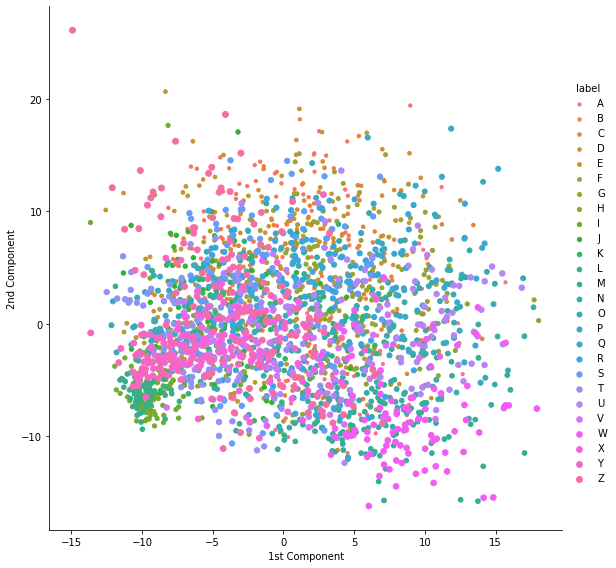

In [26]:
sns.FacetGrid(df_svd, hue='label',height=8).map(plt.scatter, '1st Component', '2nd Component', 'label_int').add_legend()
plt.show()

Check the explained variance ratio with using just 2 compnoents in SVD

In [27]:
svd.explained_variance_ratio_.sum()

0.11760722942816886

Plot the variance explained by the various number of components

In [28]:
svd.n_components = 783

svd_fitted = svd.fit_transform(df_standard)

percentage_var_explained = svd.explained_variance_ / np.sum(svd.explained_variance_)

#cumulative sum of the percentage_var_explained
cumulative_explained_variance = np.cumsum(percentage_var_explained)

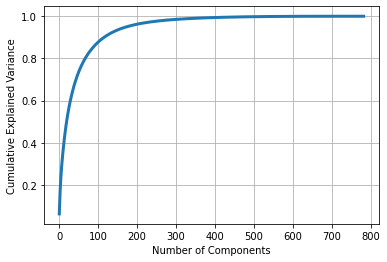

In [29]:
plt.figure(figsize=(6,4))
plt.plot(cumulative_explained_variance,linewidth=3)
plt.grid()

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

Plot looks vary similar to the PCA version with just 2 compnents

## Locally Linear Embedding (LLE)

Apply LLE to the image data

In [30]:
embeding = manifold.LocallyLinearEmbedding(n_components=2)
lle_fitted = embeding.fit_transform(df_features)

Plot the transformed data

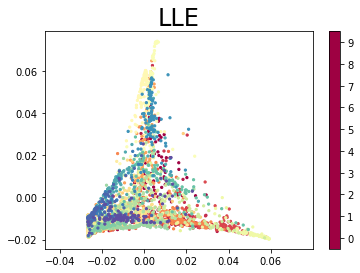

In [31]:
plt.scatter(lle_fitted[:, 0], lle_fitted[:, 1], s= 5, c=df_labels['label'].map(labels_dict_reveresed), cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('LLE', fontsize=24);

## t-distributed Stochastic Neighbor Embedding (t_SNE)

Apply t-SNE to image data.

Regerence [notebook](https://www.kaggle.com/parulpandey/visualizing-kannada-mnist-with-t-sne) from Parul Pandey

In [32]:
tsne = manifold.TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(df_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Plot the data

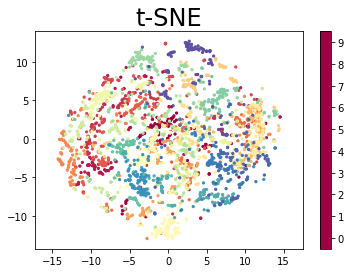

In [33]:
plt.scatter(tsne[:, 0], tsne[:, 1], s= 5, c=df_labels['label'].map(labels_dict_reveresed), cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('t-SNE', fontsize=24);

## Isometric Mapping (ISOMAP)

Apply ISOMAP to the image data set

In [34]:
isomap = manifold.Isomap(n_components=2)
isomap_fitted = isomap.fit_transform(df_features)
isomap_fitted.shape

(2600, 2)

Plot the data

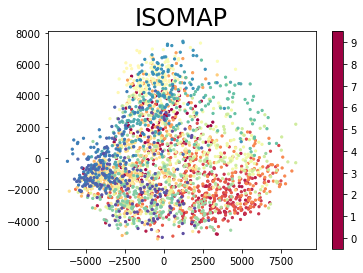

In [35]:
plt.scatter(isomap_fitted[:, 0], isomap_fitted[:, 1], s= 5, c=df_labels['label'].map(labels_dict_reveresed), cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('ISOMAP', fontsize=24);

## Uniform Manifold Approximation and Projection (UMAP)

Apply UMAP to image dataset

In [36]:
umap_model = umap.UMAP(n_components=2)
umap_fitted = umap_model.fit_transform(df_features)
umap_fitted.shape

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


(2600, 2)

Plot the data

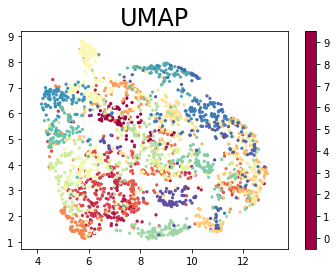

In [37]:
plt.scatter(umap_fitted[:, 0], umap_fitted[:, 1], s= 5, c=df_labels['label'].map(labels_dict_reveresed), cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP', fontsize=24);

UMAP Looks much Better than the the ISOMAP since there are more distinct clusters.

# Classification

Apply various classificatio methods for the data set.

## Train and Test Sets

Since we will be training a supervised classifier we need spearate our data into train and test splits.

In [65]:
# Download the pre-split data set's rather than create out own with Sklean.
x_train, y_train = emnist.extract_training_samples('balanced')
x_test, y_test = emnist.extract_test_samples('balanced')


#TODO: Change the custom function to get oly the capital letters from the 'balanced' dataset
# x_train, y_train = emnist.extract_training_samples('letters')
# x_test, y_test = emnist.extract_test_samples('letters')

Keep only the capital leters for this use case

In [66]:
# Define the indices only for capital letters
index_of_letters = [i for i in range(10,47)]
# index_of_capital_letters = [i for i in range(10,36)]

# Create a filtering mask
train_mask = np.isin(y_train, index_of_letters)
test_mask = np.isin(y_test, index_of_letters)

# Apply the filter to loaded data sets
x_train, y_train = x_train[train_mask], y_train[train_mask]
x_test, y_test = x_test[test_mask], y_test[test_mask]

# Reset to 0 based index for letters
y_train = y_train -10
y_test = y_test - 10

Define the capital letter dictionary

In [67]:
labels_caps = [
               # '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
               'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
               'a', 'b', 'd', 'e', 'f','g', 'h', 'n', 'q', 'r', 't',
              ]

labels_dict_caps = {key: value for key, value in enumerate(labels_caps)}

Convert the numerical labels into letters

In [68]:
# Uncomment to map the interger mapping to the correct labels
# y_train = np.vectorize(labels_dict.get)(y_train)
# y_test = np.vectorize(labels_dict.get)(y_test)


# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, 37)
y_test = tf.keras.utils.to_categorical(y_test, 37)

Normalize the data by dividing by 255 based on the RGB codes

In [69]:
x_train = x_train / 255
x_test = x_test / 255

Display the size of the training and test sets

In [70]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (88800, 28, 28)
y_train shape: (88800, 37)
Number of images in x_train 88800
Number of images in x_test 14800


## Create ML Model

Create the Layers model

In [71]:
# Importing the required Keras modules containing model and layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization

Version 1 model Architecture

In [72]:
# Creating a Sequential Model and adding the layers
# model = Sequential()
# model.add(Conv2D(28, kernel_size=(3,3), input_shape=(28, 28, 1)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(26,activation= 'softmax')) # 'softmax' 'sigmoid'

Try example of high performing model. Model architecture came from [Kaggle Article](https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist)

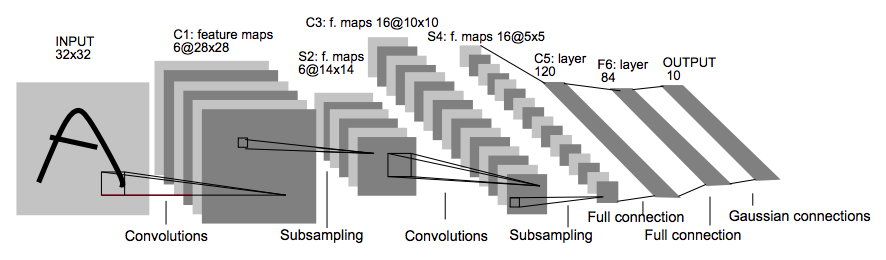

In [73]:
model = Sequential()

model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(37, activation='softmax')) #26 fro just Capital Letters

# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Display model architecture

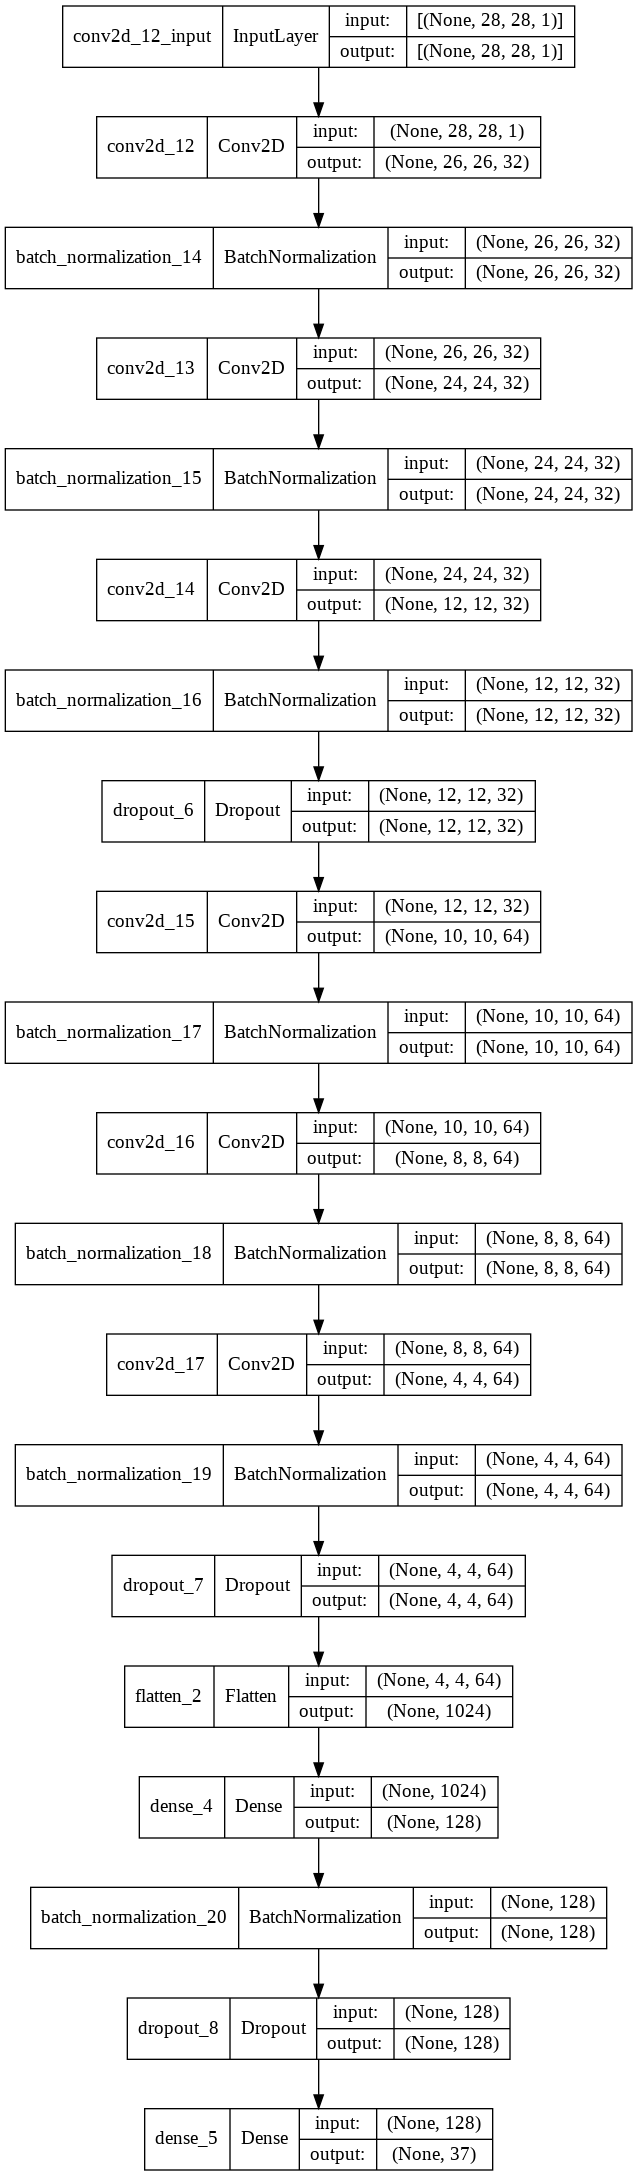

In [74]:
tf.keras.utils.plot_model(model, show_shapes=True)#, rankdir="LR")

## Fit Model

Compile and Fit Model.

Note: In Colab the fiting is much faster on GPU mode (from about 4 minutes per epoch to about 30s). Did not figure out how to speed it up with a TPU, just turining it on in the settings still ran like the CPU version @ 4min per epoch.

In [75]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [76]:
history = model.fit(x = x_train,
                    y = y_train,
                    validation_data = (x_test, y_test),
                    epochs=20) #10

Epoch 1/20
2775/2775 [==============================] - 58s 20ms/step - loss: 0.7255 - accuracy: 0.7856 - val_loss: 0.3326 - val_accuracy: 0.8955
Epoch 2/20
2775/2775 [==============================] - 50s 18ms/step - loss: 0.3752 - accuracy: 0.8805 - val_loss: 0.3010 - val_accuracy: 0.9080
Epoch 3/20
2775/2775 [==============================] - 50s 18ms/step - loss: 0.3233 - accuracy: 0.8944 - val_loss: 0.2680 - val_accuracy: 0.9141
Epoch 4/20
2775/2775 [==============================] - 47s 17ms/step - loss: 0.2972 - accuracy: 0.9021 - val_loss: 0.2548 - val_accuracy: 0.9186
Epoch 5/20
2775/2775 [==============================] - 45s 16ms/step - loss: 0.2789 - accuracy: 0.9079 - val_loss: 0.2634 - val_accuracy: 0.9154
Epoch 6/20
2775/2775 [==============================] - 43s 16ms/step - loss: 0.2621 - accuracy: 0.9110 - val_loss: 0.2460 - val_accuracy: 0.9164
Epoch 7/20
2775/2775 [==============================] - 40s 14ms/step - loss: 0.2528 - accuracy: 0.9147 - val_loss: 0.2330 -

## Review Metrics

Display the overal results

In [77]:
# history.history

Plot Training History

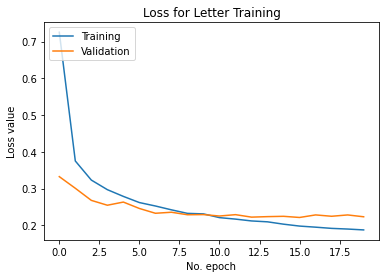

In [78]:
# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Letter Training')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(['Training', 'Validation'], loc="upper left")
plt.show()

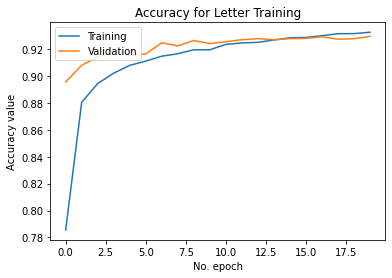

In [79]:
# Plot history: Accuracy
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy for Letter Training')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(['Training', 'Validation'], loc="upper left")
plt.show()

Plot metrics

In [128]:
# Create predictions for the whole test set an convert them to lables (A,B,C...)
y_test_preds = model.predict(x_test)
y_test_preds = np.argmax(y_test_preds, axis=1)

# Convert to labels
y_test_as_labels = np.vectorize(labels_dict_caps.get)(np.argmax(y_test, axis=1))
y_test_preds_as_labels = np.vectorize(labels_dict_caps.get)(y_test_preds)

Create a confusion matrix:

In [129]:
cm = confusion_matrix(y_test_as_labels, y_test_preds_as_labels)

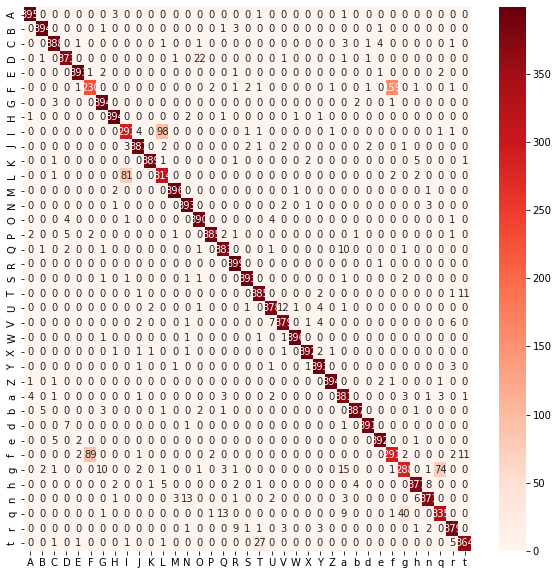

In [130]:
plt.figure(figsize=[10,10])
sns.heatmap(cm, cmap="Reds", annot=True, fmt='.0f', xticklabels = labels_dict_caps.values(), yticklabels= labels_dict_caps.values()) 
plt.show()

In [131]:
print(classification_report(y_test_as_labels, y_test_preds_as_labels))

              precision    recall  f1-score   support

           A       0.98      0.99      0.98       400
           B       0.98      0.98      0.98       400
           C       0.97      0.97      0.97       400
           D       0.95      0.93      0.94       400
           E       0.98      0.98      0.98       400
           F       0.71      0.57      0.64       400
           G       0.95      0.98      0.97       400
           H       0.98      0.98      0.98       400
           I       0.77      0.73      0.75       400
           J       0.97      0.97      0.97       400
           K       0.99      0.97      0.98       400
           L       0.74      0.79      0.76       400
           M       0.99      0.99      0.99       400
           N       0.95      0.98      0.97       400
           O       0.93      0.97      0.95       400
           P       0.99      0.96      0.97       400
           Q       0.94      0.96      0.95       400
           R       0.95    

## Save and Load Model

Save the model

In [80]:
# !rm -rf model_conv_v0`

In [81]:
model_name = 'model_conv_v03'
model.save(f'{model_name}.h5')

In [ ]:
# reloaded_model = tf.keras.models.load_model('model_conv_v01.h5')

For Colab a couple of extra steps are need to download the zip file.

In [ ]:
# !zip -r /content/{model_name}.zip $model_name/
# from google.colab import files
# files.download(f'{model_name}.zip')

Load Model from ziped folder

In [ ]:
# !unzip /content/{model_name}.zip -d /content/{model_name}

In [ ]:
# reloaded_model = tf.keras.models.load_model('model_conv_v01')

In [ ]:
# reloaded_model.evaluate(x_test, y_test)

## Evaluate and Predict

Evaluate the Model

In [111]:
model.evaluate(x_test, y_test)

463/463 [==============================] - 3s 7ms/step - loss: 0.2234 - accuracy: 0.9295


[0.22341465950012207, 0.9294594526290894]

Predict on individual images

Predicted Label: g
Actual Label: g


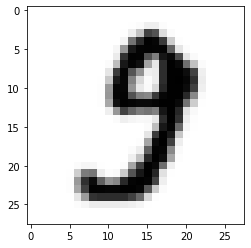

In [116]:
image_index = 0
plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
pred = model.predict(x_test[image_index].reshape(1, 28, 28, 1))
# pred = reloaded_model.predict(x_test[image_index].reshape(1, 28, 28, 1))
# print(pred[0])
pred = pred.argmax()
pred = labels_dict_caps[pred]
print(f'Predicted Label: {pred}')
actual_label = labels_dict_caps[y_test[image_index].argmax()]
print(f'Actual Label: {actual_label}')

Explore creating probability plots from the predictions

In [114]:
def create_probability_df(model_prediction):
    df_temp = pd.DataFrame(model_prediction, columns=labels_dict_caps.values())
    df_temp = df_temp.transpose().reset_index()
    df_temp.columns = ['Label','Probability']

    return df_temp

In [115]:
import plotly.express as px

df_temp_for_plot = create_probability_df(model.predict(x_test[0].reshape(1, 28, 28, 1)))
fig = px.bar(df_temp_for_plot, x='Label', y='Probability')
fig.show()

# Nest Steps



*   Apply auto ML to see scores
*   Build front end system to take in custom digits and predict on



# Reference

**Data Set References**

EMNIST dataset: https://www.nist.gov/itl/iad/image-group/emnist-dataset

Direct download: http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip

Cohen, G., Afshar, S., Tapson, J., & van Schaik, A. (2017). EMNIST: an extension of MNIST to handwritten letters. Retrieved from http://arxiv.org/abs/1702.05373

Importing and formating Image data inspired by [ArangurenAndres/EMNSIT-Image-classification](https://github.com/ArangurenAndres/EMNSIT-Image-classification/blob/master/cognition_project.ipynb)

Mapping and oringal file reference [Website](https://www.kaggle.com/crawford/emnist/version/1?select=emnist-balanced-mapping.txt)


**Data Reduction References**

Parts of the visualation nad PCA were inspired by [Rahul228646's Kaggle notebook](https://www.kaggle.com/rahul228646/pca-mnist)

Example Data Visualizations for Images from [Kaggle Notebook](https://www.kaggle.com/parulpandey/visualizing-kannada-mnist-with-t-sne)

**Classification Reference**

Image Classification in 10 Minutes with MNIST Dataset [Article](https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d)

How to Develop a CNN for MNIST [Article](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/)